# MONTE CARLO DROPOUT
Incerteza Epistêmica em Redes Neurais - Gerson Eduardo de Mello 

Esta é uma aplicação do método de incerteza em redes neurais proposto por Yarin Gal. O Dataset escolhido foi O 
Airfoil Self-Noise Data Set (http://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise ) retirado do UCL Machine Learn Repository. A variável predita escolhida foi a "Pressure" e todas as demais foram consideradas como variáveis preditoras. 

#Descrição do método proposto por Yarin Gal: 

Em 2015, Yarin Gal mostrou que é possível obter incerteza a partir de redes neurais quase que gratuitamente, se olhássemos técnicas de regularização estocásticas, como Dropout, sob uma perspectiva Bayesiana. Dropout (Srivastava et al, 2014) é uma técnica utilizada na maioria das redes neurais modernas para prevenir sobre-ajustamento. Durante o treinamento, Dropout funciona zerando aleatoriamente uma percentagens de neurônios nas camadas da rede neural. No momento de fazer previsões, todos os neurônios são mantidos e a rede neural atua como uma grande mistura de sub-redes menores.
Durante o treinamento do modelo, nada muda; mas, durante o teste mantemos a probabilidade de Dropout fixada durante o treino e realizamos T  forward-pass pela rede, coletando assim T  previsões y para cada amostra. Assim para cada ponto teremos uma previsão para a média e uma previsão para a variância, que será nossa medida de incerteza.
 

# Manipulando os dados 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-learn



%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [2]:
# importando os dados  

In [3]:
df=pd.read_csv('airfoil.csv')

In [4]:
df

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Após a avaliação da distribuição dos dados para cada uma das variáveis, pode-se aplicar a normalização que é a mais apropriada do que a padronização uma vez que oas distribuições não seguem uma normalidade

In [5]:
from sklearn.preprocessing import MinMaxScaler 

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
df_n = scaler.fit_transform(df)
print(df_n)

[[0.03030303 0.         1.         1.         0.03900472 0.60682852]
 [0.04040404 0.         1.         1.         0.03900472 0.58023772]
 [0.0530303  0.         1.         1.         0.03900472 0.60018082]
 ...
 [0.19191919 0.7027027  0.27272727 0.19949495 0.90411066 0.08572872]
 [0.24242424 0.7027027  0.27272727 0.19949495 0.90411066 0.07562422]
 [0.30808081 0.7027027  0.27272727 0.19949495 0.90411066 0.02191081]]


In [7]:
df_n=pd.DataFrame(df_n)

In [8]:
y=df_n[5]

In [9]:
X=df_n[df_n.columns[0:5]]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True, random_state=32)

# construção e treino da rede neural 

In [11]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [12]:
#construimos a rede neural

In [13]:
n_input = 5  # numero de entradas das rede neural 
num_out = 1
p_dropout = 0.5 # probabilidade dropout 

lbd = 1e-4  # L2- força de regularização 

model = Sequential()
model.add(Dropout(.05, input_shape=(n_input,)))
model.add(Dense(100, activation='relu', input_shape=(n_input,), kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropout))
model.add(Dense(num_out, activation=None))
model.summary()

opt = Adam(lr=1e-3) 

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_absolute_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 100)               600       
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,801
Trainable params: 10,801
Non-traina

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
#treinamos nossa rede por 15000 interações . Cada mini-lote terá 1/5das amostras e assim treinaremos por
# 3000 épocas ou 15000 iterações.

In [15]:
epochs = 10000
model.fit(X_train, y_train,
            batch_size=X_train.shape[0] // 1,
            epochs=epochs,
            verbose=0)

In [16]:
#Avaliamos a performance do modelo )

In [17]:
from sklearn import metrics

y_hat_train = model.predict(X_train)# passamos  o conjunto de treino pela rede e obtemos as predições 


46/46 [==============================] - 0s 670us/step


In [18]:
y_hat_test = model.predict(X_test)# passamos  o conjunto de teste pela rede e obtemos as predições


1/1 [==============================] - 0s 38ms/step


In [19]:
# métricas do treino

In [20]:
MAE_T=metrics.mean_absolute_error(y_train, y_hat_train)
R2_T=metrics.r2_score(y_train, y_hat_train);
RMSE_T=metrics.mean_squared_error(y_train, y_hat_train)

In [21]:
MAE_T,R2_T,RMSE_T

(0.051587203051603095, 0.864097756784743, 0.0046078615902120845)

In [22]:
# métricas do teste

In [23]:
MAE_t=metrics.mean_absolute_error(y_test, y_hat_test)
R2_t=metrics.r2_score(y_test, y_hat_test);
RMSE_t=metrics.mean_squared_error(y_test, y_hat_test)

In [24]:
MAE_t,R2_t,RMSE_t

(0.043140834597606, 0.8587270563560752, 0.002849045876938789)

Determinação do Erro aleatório e erro sistemáticoem todo o dataset

In [25]:
previsão=model.predict(X[:1503])# passando todos os dados pela rede ( sem distinção de treino e teste)

47/47 [==============================] - 0s 820us/step


In [26]:
X[:1503]

,0,1,2,3,4
0,0.030303,0.000000,1.000000,1.000000,0.039005
1,0.040404,0.000000,1.000000,1.000000,0.039005
2,0.053030,0.000000,1.000000,1.000000,0.039005
3,0.070707,0.000000,1.000000,1.000000,0.039005
4,0.090909,0.000000,1.000000,1.000000,0.039005
...,...,...,...,...,...
1498,0.116162,0.702703,0.272727,0.199495,0.904111
1499,0.148990,0.702703,0.272727,0.199495,0.904111
1500,0.191919,0.702703,0.272727,0.199495,0.904111
1501,0.242424,0.702703,0.272727,0.199495,0.904111


In [27]:
previsão=pd.DataFrame(previsão)

In [28]:
previsão

,0
0,0.632352
1,0.638426
2,0.634966
3,0.628771
4,0.618464
...,...
1498,0.250925
1499,0.215135
1500,0.182475
1501,0.161792


In [29]:
df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão 

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\1795452580.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume4=pd.concat([X,y,previsão],axis=1) #criando data frame com os valores do vetor x mais a coluna da previsão


In [30]:
df.resume4

,0,1,2,3,4,5,0
0,0.030303,0.000000,1.000000,1.000000,0.039005,0.606829,0.632352
1,0.040404,0.000000,1.000000,1.000000,0.039005,0.580238,0.638426
2,0.053030,0.000000,1.000000,1.000000,0.039005,0.600181,0.634966
3,0.070707,0.000000,1.000000,1.000000,0.039005,0.643790,0.628771
4,0.090909,0.000000,1.000000,1.000000,0.039005,0.640333,0.618464
...,...,...,...,...,...,...,...
1498,0.116162,0.702703,0.272727,0.199495,0.904111,0.183051,0.250925
1499,0.148990,0.702703,0.272727,0.199495,0.904111,0.156194,0.215135
1500,0.191919,0.702703,0.272727,0.199495,0.904111,0.085729,0.182475
1501,0.242424,0.702703,0.272727,0.199495,0.904111,0.075624,0.161792


In [31]:
df.resume4.columns=['x1','x2','x3','x4','x5','y','predict']

In [32]:
df.resume4

,x1,x2,x3,x4,x5,y,predict
0,0.030303,0.000000,1.000000,1.000000,0.039005,0.606829,0.632352
1,0.040404,0.000000,1.000000,1.000000,0.039005,0.580238,0.638426
2,0.053030,0.000000,1.000000,1.000000,0.039005,0.600181,0.634966
3,0.070707,0.000000,1.000000,1.000000,0.039005,0.643790,0.628771
4,0.090909,0.000000,1.000000,1.000000,0.039005,0.640333,0.618464
...,...,...,...,...,...,...,...
1498,0.116162,0.702703,0.272727,0.199495,0.904111,0.183051,0.250925
1499,0.148990,0.702703,0.272727,0.199495,0.904111,0.156194,0.215135
1500,0.191919,0.702703,0.272727,0.199495,0.904111,0.085729,0.182475
1501,0.242424,0.702703,0.272727,0.199495,0.904111,0.075624,0.161792


In [33]:

erro=df.resume4['predict']-df.resume4['y']#determinando o erro emtre o real e a predição 

es=erro.loc[:,].mean()

ea=erro.loc[:,].std()


In [34]:
erro=pd.DataFrame(erro)

In [35]:
erro

,0
0,0.025524
1,0.058188
2,0.034785
3,-0.015019
4,-0.021869
...,...
1498,0.067874
1499,0.058940
1500,0.096747
1501,0.086168


In [36]:
ea

0.06732251439037204

In [37]:
es

0.006502297590038138

In [38]:
erro.describe()# confirmando os resultados

,0
count,1503.000000
mean,0.006502
std,0.067323
min,-0.350489
25%,-0.035520
50%,0.009378
75%,0.047292
max,0.267748


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


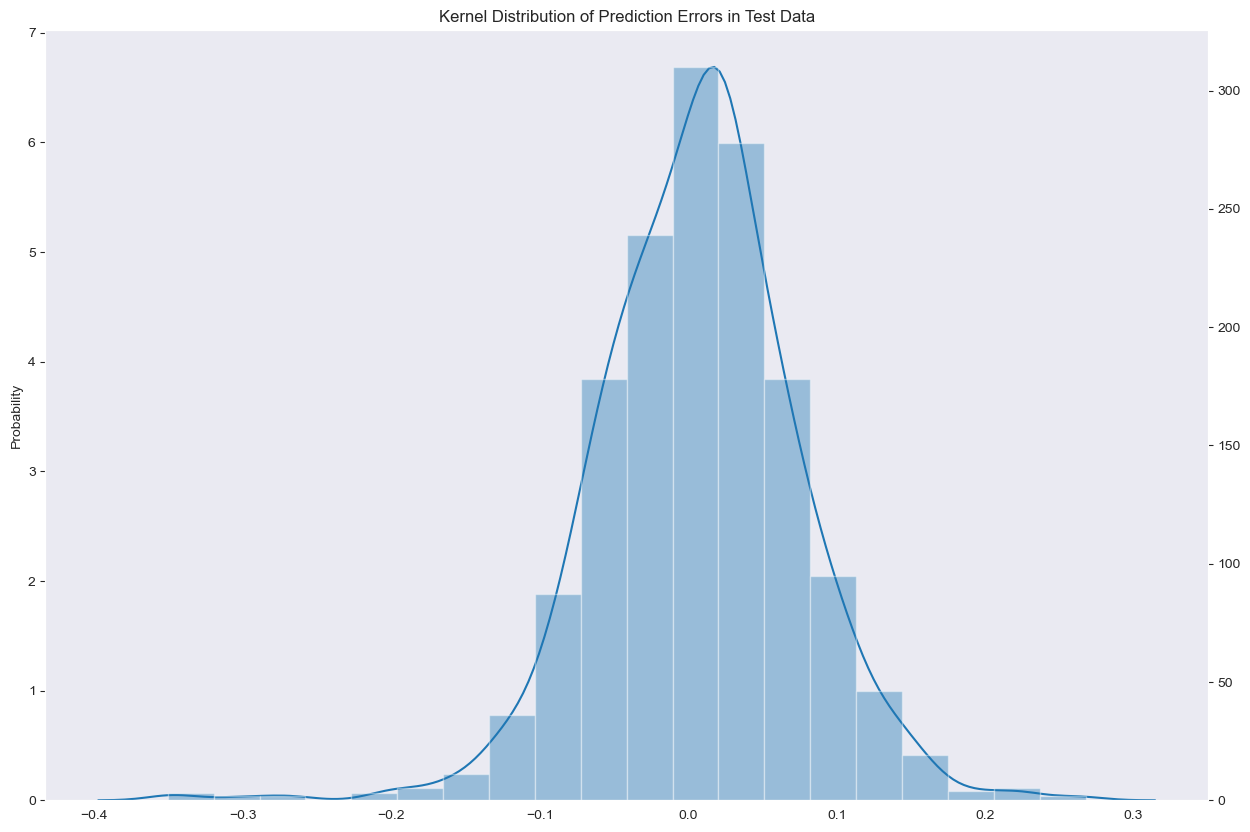

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [40]:
# elaboração do gráfico ordenando os dados em ordem e plotando os valores reais e predito no conjunto de teste 

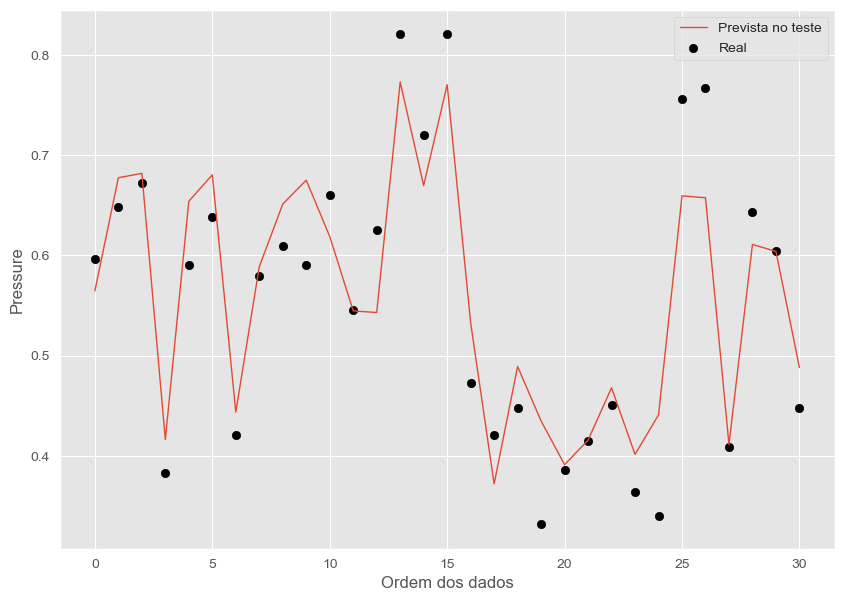

In [41]:
# avaliação conjunto de teste
n = 31
plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(range(n), y_hat_test, label="Prevista no teste", lw=1)#y_hat_test é a prediçã osobre os dados de teste
plt.scatter(range(n), y_test, color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda1.png")
plt.show()

Acima, a previsão é feita da forma tradicional, isto é, colocando a probabilidade de Dropout em 0%, usando assim toda a capacidade da rede. Esse é o padrão do Keras e precisaremos rescrevê-lo para implementar Monte-Carlo Dropout, no qual mantemos as probabilidades de Dropout de treino também durante as previsões. Abaixo, vamos definir uma função que retornará a última camada da rede, (as previsões) dada a camada de entrada (as variáveis). Além disso, vamos definir que está função será usada tal como durante o treinamento, passando K.learning_phase().
Abaixo realizamos 1000 forwad-passes pela rede neural e obtemos 1000 previsões para cada ponto.

# MC DROPOUT

In [42]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mc = np.array([predict_stochastic([X_test]) for _ in range(T)])

y_hat_mc = y_hat_mc.reshape(-1, y_test.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [43]:
y_hat_mc.shape

(31, 1000)

In [44]:
y_hat_mc=pd.DataFrame(y_hat_mc)

In [45]:
y_hat_mc # são as 1000 previsões realizadas pela rede Dropout para cada vetor teste

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.615842,0.779356,0.624588,0.607294,0.696091,0.552426,0.701880,0.547975,0.483454,0.587033,...,0.677779,0.505819,0.517132,0.563025,0.625017,0.589017,0.582799,0.557152,0.573224,0.481937
1,0.616545,0.656804,0.656261,0.656332,0.649475,0.657565,0.650997,0.652842,0.648376,0.662468,...,0.635305,0.635525,0.575658,0.607636,0.690658,0.690738,0.649947,0.654663,0.599329,0.628058
2,0.663843,0.671726,0.684020,0.640013,0.656673,0.657885,0.722261,0.655166,0.666328,0.709737,...,0.718039,0.686157,0.686959,0.738214,0.679805,0.676440,0.645311,0.675193,0.696361,0.728676
3,0.439510,0.381410,0.415185,0.417602,0.406032,0.426219,0.364101,0.416850,0.411699,0.398680,...,0.650900,0.415361,0.376107,0.440628,0.426553,0.400324,0.367190,0.426980,0.432868,0.420175
4,0.623202,0.550730,0.674227,0.578087,0.620630,0.647511,0.666770,0.562167,0.590178,0.654389,...,0.696859,0.715815,0.599893,0.633687,0.651073,0.627404,0.628555,0.607492,0.638221,0.685268
5,0.689226,0.595011,0.691941,0.684367,0.625696,0.690116,0.681484,0.653111,0.747518,0.562736,...,0.672080,0.714034,0.715250,0.714512,0.662775,0.643902,0.708389,0.717639,0.681608,0.625193
6,0.634097,0.435851,0.323664,0.436434,0.423108,0.445570,0.405001,0.405285,0.430098,0.381883,...,0.595286,0.415094,0.384513,0.403035,0.373726,0.345427,0.375774,0.360243,0.371881,0.389953
7,0.603805,0.611093,0.565183,0.609562,0.630754,0.616438,0.553797,0.536901,0.554441,0.658071,...,0.583922,0.545720,0.583380,0.534359,0.551708,0.600789,0.584958,0.557794,0.579072,0.557992
8,0.574322,0.620804,0.562266,0.581497,0.579346,0.580361,0.556037,0.666724,0.606787,0.646015,...,0.592847,0.613318,0.456129,0.612042,0.534123,0.630939,0.575177,0.575475,0.690674,0.669172
9,0.572297,0.689827,0.654646,0.586706,0.651608,0.593984,0.657153,0.607087,0.672801,0.663870,...,0.608522,0.648302,0.655842,0.603510,0.655346,0.679703,0.642159,0.611983,0.680032,0.629262


In [46]:
yhat=pd.DataFrame(y_hat_mc)

In [47]:
yhat

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.615842,0.779356,0.624588,0.607294,0.696091,0.552426,0.701880,0.547975,0.483454,0.587033,...,0.677779,0.505819,0.517132,0.563025,0.625017,0.589017,0.582799,0.557152,0.573224,0.481937
1,0.616545,0.656804,0.656261,0.656332,0.649475,0.657565,0.650997,0.652842,0.648376,0.662468,...,0.635305,0.635525,0.575658,0.607636,0.690658,0.690738,0.649947,0.654663,0.599329,0.628058
2,0.663843,0.671726,0.684020,0.640013,0.656673,0.657885,0.722261,0.655166,0.666328,0.709737,...,0.718039,0.686157,0.686959,0.738214,0.679805,0.676440,0.645311,0.675193,0.696361,0.728676
3,0.439510,0.381410,0.415185,0.417602,0.406032,0.426219,0.364101,0.416850,0.411699,0.398680,...,0.650900,0.415361,0.376107,0.440628,0.426553,0.400324,0.367190,0.426980,0.432868,0.420175
4,0.623202,0.550730,0.674227,0.578087,0.620630,0.647511,0.666770,0.562167,0.590178,0.654389,...,0.696859,0.715815,0.599893,0.633687,0.651073,0.627404,0.628555,0.607492,0.638221,0.685268
5,0.689226,0.595011,0.691941,0.684367,0.625696,0.690116,0.681484,0.653111,0.747518,0.562736,...,0.672080,0.714034,0.715250,0.714512,0.662775,0.643902,0.708389,0.717639,0.681608,0.625193
6,0.634097,0.435851,0.323664,0.436434,0.423108,0.445570,0.405001,0.405285,0.430098,0.381883,...,0.595286,0.415094,0.384513,0.403035,0.373726,0.345427,0.375774,0.360243,0.371881,0.389953
7,0.603805,0.611093,0.565183,0.609562,0.630754,0.616438,0.553797,0.536901,0.554441,0.658071,...,0.583922,0.545720,0.583380,0.534359,0.551708,0.600789,0.584958,0.557794,0.579072,0.557992
8,0.574322,0.620804,0.562266,0.581497,0.579346,0.580361,0.556037,0.666724,0.606787,0.646015,...,0.592847,0.613318,0.456129,0.612042,0.534123,0.630939,0.575177,0.575475,0.690674,0.669172
9,0.572297,0.689827,0.654646,0.586706,0.651608,0.593984,0.657153,0.607087,0.672801,0.663870,...,0.608522,0.648302,0.655842,0.603510,0.655346,0.679703,0.642159,0.611983,0.680032,0.629262


In [48]:
#vamos calcular a média dos 1000 resultados para cada amostra de teste

In [49]:
yhat['mean']=yhat.apply(np.mean,axis=1)

In [50]:
yhat

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,mean
0,0.615842,0.779356,0.624588,0.607294,0.696091,0.552426,0.701880,0.547975,0.483454,0.587033,...,0.505819,0.517132,0.563025,0.625017,0.589017,0.582799,0.557152,0.573224,0.481937,0.592429
1,0.616545,0.656804,0.656261,0.656332,0.649475,0.657565,0.650997,0.652842,0.648376,0.662468,...,0.635525,0.575658,0.607636,0.690658,0.690738,0.649947,0.654663,0.599329,0.628058,0.660891
2,0.663843,0.671726,0.684020,0.640013,0.656673,0.657885,0.722261,0.655166,0.666328,0.709737,...,0.686157,0.686959,0.738214,0.679805,0.676440,0.645311,0.675193,0.696361,0.728676,0.677656
3,0.439510,0.381410,0.415185,0.417602,0.406032,0.426219,0.364101,0.416850,0.411699,0.398680,...,0.415361,0.376107,0.440628,0.426553,0.400324,0.367190,0.426980,0.432868,0.420175,0.420320
4,0.623202,0.550730,0.674227,0.578087,0.620630,0.647511,0.666770,0.562167,0.590178,0.654389,...,0.715815,0.599893,0.633687,0.651073,0.627404,0.628555,0.607492,0.638221,0.685268,0.627782
5,0.689226,0.595011,0.691941,0.684367,0.625696,0.690116,0.681484,0.653111,0.747518,0.562736,...,0.714034,0.715250,0.714512,0.662775,0.643902,0.708389,0.717639,0.681608,0.625193,0.661358
6,0.634097,0.435851,0.323664,0.436434,0.423108,0.445570,0.405001,0.405285,0.430098,0.381883,...,0.415094,0.384513,0.403035,0.373726,0.345427,0.375774,0.360243,0.371881,0.389953,0.432333
7,0.603805,0.611093,0.565183,0.609562,0.630754,0.616438,0.553797,0.536901,0.554441,0.658071,...,0.545720,0.583380,0.534359,0.551708,0.600789,0.584958,0.557794,0.579072,0.557992,0.594229
8,0.574322,0.620804,0.562266,0.581497,0.579346,0.580361,0.556037,0.666724,0.606787,0.646015,...,0.613318,0.456129,0.612042,0.534123,0.630939,0.575177,0.575475,0.690674,0.669172,0.620449
9,0.572297,0.689827,0.654646,0.586706,0.651608,0.593984,0.657153,0.607087,0.672801,0.663870,...,0.648302,0.655842,0.603510,0.655346,0.679703,0.642159,0.611983,0.680032,0.629262,0.640608


In [51]:
#separamos novamente os 1000 resultados retitrando a coluna média 

In [52]:
yhatd=yhat.iloc[:,0:1000]

In [53]:
yhatd

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.615842,0.779356,0.624588,0.607294,0.696091,0.552426,0.701880,0.547975,0.483454,0.587033,...,0.677779,0.505819,0.517132,0.563025,0.625017,0.589017,0.582799,0.557152,0.573224,0.481937
1,0.616545,0.656804,0.656261,0.656332,0.649475,0.657565,0.650997,0.652842,0.648376,0.662468,...,0.635305,0.635525,0.575658,0.607636,0.690658,0.690738,0.649947,0.654663,0.599329,0.628058
2,0.663843,0.671726,0.684020,0.640013,0.656673,0.657885,0.722261,0.655166,0.666328,0.709737,...,0.718039,0.686157,0.686959,0.738214,0.679805,0.676440,0.645311,0.675193,0.696361,0.728676
3,0.439510,0.381410,0.415185,0.417602,0.406032,0.426219,0.364101,0.416850,0.411699,0.398680,...,0.650900,0.415361,0.376107,0.440628,0.426553,0.400324,0.367190,0.426980,0.432868,0.420175
4,0.623202,0.550730,0.674227,0.578087,0.620630,0.647511,0.666770,0.562167,0.590178,0.654389,...,0.696859,0.715815,0.599893,0.633687,0.651073,0.627404,0.628555,0.607492,0.638221,0.685268
5,0.689226,0.595011,0.691941,0.684367,0.625696,0.690116,0.681484,0.653111,0.747518,0.562736,...,0.672080,0.714034,0.715250,0.714512,0.662775,0.643902,0.708389,0.717639,0.681608,0.625193
6,0.634097,0.435851,0.323664,0.436434,0.423108,0.445570,0.405001,0.405285,0.430098,0.381883,...,0.595286,0.415094,0.384513,0.403035,0.373726,0.345427,0.375774,0.360243,0.371881,0.389953
7,0.603805,0.611093,0.565183,0.609562,0.630754,0.616438,0.553797,0.536901,0.554441,0.658071,...,0.583922,0.545720,0.583380,0.534359,0.551708,0.600789,0.584958,0.557794,0.579072,0.557992
8,0.574322,0.620804,0.562266,0.581497,0.579346,0.580361,0.556037,0.666724,0.606787,0.646015,...,0.592847,0.613318,0.456129,0.612042,0.534123,0.630939,0.575177,0.575475,0.690674,0.669172
9,0.572297,0.689827,0.654646,0.586706,0.651608,0.593984,0.657153,0.607087,0.672801,0.663870,...,0.608522,0.648302,0.655842,0.603510,0.655346,0.679703,0.642159,0.611983,0.680032,0.629262


In [54]:
#vamos calcular o desvio padrão dos 1000 resultados dos dados de teste

In [55]:
yhatd['std']=yhatd.apply(np.std,axis=1)

In [56]:
yhatd

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,std
0,0.615842,0.779356,0.624588,0.607294,0.696091,0.552426,0.701880,0.547975,0.483454,0.587033,...,0.505819,0.517132,0.563025,0.625017,0.589017,0.582799,0.557152,0.573224,0.481937,0.064060
1,0.616545,0.656804,0.656261,0.656332,0.649475,0.657565,0.650997,0.652842,0.648376,0.662468,...,0.635525,0.575658,0.607636,0.690658,0.690738,0.649947,0.654663,0.599329,0.628058,0.043593
2,0.663843,0.671726,0.684020,0.640013,0.656673,0.657885,0.722261,0.655166,0.666328,0.709737,...,0.686157,0.686959,0.738214,0.679805,0.676440,0.645311,0.675193,0.696361,0.728676,0.039343
3,0.439510,0.381410,0.415185,0.417602,0.406032,0.426219,0.364101,0.416850,0.411699,0.398680,...,0.415361,0.376107,0.440628,0.426553,0.400324,0.367190,0.426980,0.432868,0.420175,0.073088
4,0.623202,0.550730,0.674227,0.578087,0.620630,0.647511,0.666770,0.562167,0.590178,0.654389,...,0.715815,0.599893,0.633687,0.651073,0.627404,0.628555,0.607492,0.638221,0.685268,0.045306
5,0.689226,0.595011,0.691941,0.684367,0.625696,0.690116,0.681484,0.653111,0.747518,0.562736,...,0.714034,0.715250,0.714512,0.662775,0.643902,0.708389,0.717639,0.681608,0.625193,0.052098
6,0.634097,0.435851,0.323664,0.436434,0.423108,0.445570,0.405001,0.405285,0.430098,0.381883,...,0.415094,0.384513,0.403035,0.373726,0.345427,0.375774,0.360243,0.371881,0.389953,0.065812
7,0.603805,0.611093,0.565183,0.609562,0.630754,0.616438,0.553797,0.536901,0.554441,0.658071,...,0.545720,0.583380,0.534359,0.551708,0.600789,0.584958,0.557794,0.579072,0.557992,0.037386
8,0.574322,0.620804,0.562266,0.581497,0.579346,0.580361,0.556037,0.666724,0.606787,0.646015,...,0.613318,0.456129,0.612042,0.534123,0.630939,0.575177,0.575475,0.690674,0.669172,0.045371
9,0.572297,0.689827,0.654646,0.586706,0.651608,0.593984,0.657153,0.607087,0.672801,0.663870,...,0.648302,0.655842,0.603510,0.655346,0.679703,0.642159,0.611983,0.680032,0.629262,0.038154


In [57]:
#Abaixo os valores reais para y do conjunto de teste

In [58]:
y_test=pd.DataFrame(y_test)

In [59]:
y_test

,5
1154,0.596591
475,0.648363
458,0.671870
43,0.383147
533,0.590555
1366,0.638046
537,0.420906
273,0.579068
428,0.609434
381,0.590342


In [60]:
#resetando o índice 

In [61]:
y_test=y_test.reset_index(drop=True)

In [62]:
y_test

,5
0,0.596591
1,0.648363
2,0.671870
3,0.383147
4,0.590555
5,0.638046
6,0.420906
7,0.579068
8,0.609434
9,0.590342


In [63]:
#retirado a coluna 0

In [64]:
mean=yhat.iloc[:,1000]

In [65]:
mean=pd.DataFrame(mean)

In [66]:
desvpad=yhatd.iloc[:,1000]

In [67]:
desvpad=pd.DataFrame(desvpad)

In [68]:
#colocar tudo em uma tabela

In [69]:
df.resume=pd.concat([y_test,mean,desvpad],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\1750862409.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume=pd.concat([y_test,mean,desvpad],axis=1)


In [70]:
df.resume

,5,mean,std
0,0.596591,0.592429,0.064060
1,0.648363,0.660891,0.043593
2,0.671870,0.677656,0.039343
3,0.383147,0.420320,0.073088
4,0.590555,0.627782,0.045306
5,0.638046,0.661358,0.052098
6,0.420906,0.432333,0.065812
7,0.579068,0.594229,0.037386
8,0.609434,0.620449,0.045371
9,0.590342,0.640608,0.038154


In [71]:
erro2=df.resume['mean']-df.resume[5]


In [72]:
erro2

0    -0.004162
1     0.012527
2     0.005787
3     0.037173
4     0.037228
5     0.023312
6     0.011428
7     0.015161
8     0.011015
9     0.050266
10   -0.067955
11    0.011442
12   -0.071664
13   -0.078095
14   -0.076041
15   -0.081284
16    0.070219
17   -0.021360
18    0.033055
19    0.149802
20    0.001679
21   -0.001875
22    0.007977
23    0.039895
24    0.099314
25   -0.127376
26   -0.096882
27   -0.003490
28   -0.023899
29   -0.034748
30    0.026778
dtype: float64

In [73]:
es2=erro2.loc[:,].mean()

ea2=erro2.loc[:,].std()


In [74]:
es2

-0.0014443294582756796

In [75]:
es

0.006502297590038138

In [76]:
ea2

0.05870802901153594

In [77]:
ea

0.06732251439037204

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


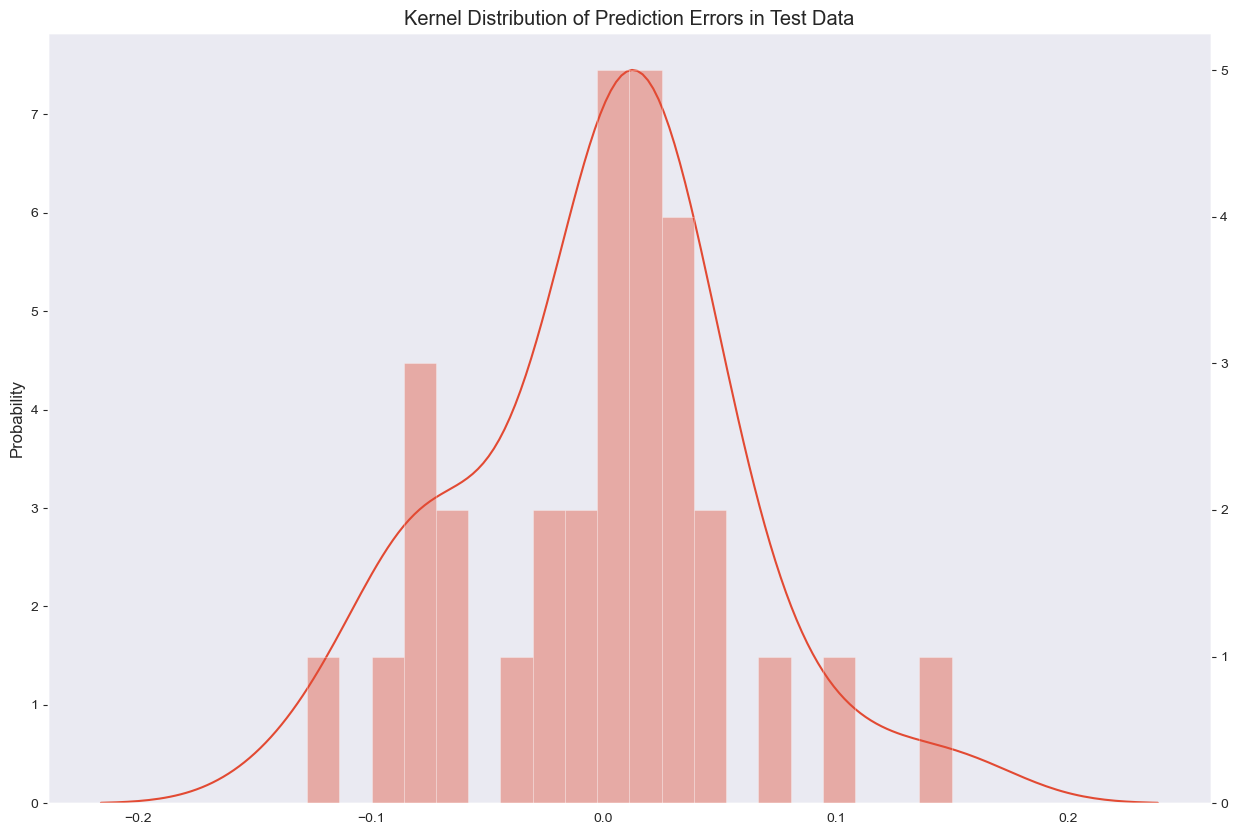

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro2, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro2, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [79]:
import tensorflow as tf
import numpy as np
from keras import backend as K

T = 1000

tf.keras.backend.set_learning_phase(1)

predict_stochastic = K.function([model.layers[0].input], [model.layers[-1].output])

y_hat_mct = np.array([predict_stochastic([X]) for _ in range(T)])

y_hat_mct = y_hat_mct.reshape(-1, y.shape[0]).T

C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [80]:
yhatt=pd.DataFrame(y_hat_mct)

In [81]:
yhatt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.626279,0.615561,0.683831,0.547642,0.647580,0.607055,0.637322,0.620802,0.657956,0.598585,...,0.557316,0.638351,0.594001,0.619125,0.635612,0.644553,0.620729,0.580818,0.595324,0.601111
1,0.659145,0.651122,0.639603,0.592306,0.643714,0.686509,0.653327,0.624129,0.737615,0.671441,...,0.700185,0.674847,0.601280,0.534214,0.613360,0.654501,0.618628,0.673406,0.650112,0.578178
2,0.624234,0.653326,0.621115,0.654312,0.589326,0.663682,0.700618,0.622437,0.642922,0.613806,...,0.640268,0.623819,0.637526,0.625802,0.651102,0.648216,0.613698,0.631508,0.568353,0.615294
3,0.605661,0.576741,0.621781,0.542642,0.654425,0.601225,0.612750,0.588627,0.603812,0.668653,...,0.599655,0.567371,0.711441,0.687622,0.635005,0.670465,0.597093,0.664118,0.606451,0.671169
4,0.581281,0.582724,0.624672,0.602186,0.611796,0.668977,0.574888,0.597621,0.637237,0.614114,...,0.632662,0.510911,0.632691,0.600417,0.641042,0.627165,0.605415,0.506613,0.634101,0.590324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,0.326163,0.225565,0.342956,0.256044,0.148162,0.413242,0.238927,0.179492,0.286984,0.295710,...,0.200424,0.263194,0.313761,0.265606,0.226785,0.190416,0.247571,0.228967,0.272535,0.217435
1499,0.183019,0.212979,0.207770,0.196863,0.098972,0.134825,0.106573,0.206247,0.158907,0.157991,...,0.167039,0.197361,0.236127,0.171041,0.133442,0.499398,0.175413,0.240175,0.410274,0.342930
1500,0.031577,0.066116,0.230932,0.137966,0.204638,0.270451,0.073717,0.193260,0.321577,0.158410,...,0.232224,-0.011400,-0.148715,0.300179,0.220014,0.116721,0.085779,0.278098,0.176693,0.229939
1501,-0.021104,0.079425,0.351566,0.051529,0.061273,0.201526,0.300455,0.162040,0.152979,-0.126403,...,0.011957,0.277680,0.147743,0.030847,0.111584,0.075274,0.168890,0.090249,0.102588,0.287041


In [82]:
meanyhatt=yhatt.apply(np.mean,axis=1)

In [83]:
desvyhatt=yhatt.apply(np.std,axis=1)

In [84]:
erro3=meanyhatt-y

In [85]:
erro3

0       0.022430
1       0.051272
2       0.028261
3      -0.024320
4      -0.034985
          ...   
1498    0.074626
1499    0.070699
1500    0.101526
1501    0.086836
1502    0.127607
Length: 1503, dtype: float64

In [86]:
es3=erro3.loc[:,].mean()

ea3=erro3.loc[:,].std()


C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\AdmPDI\Documents\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


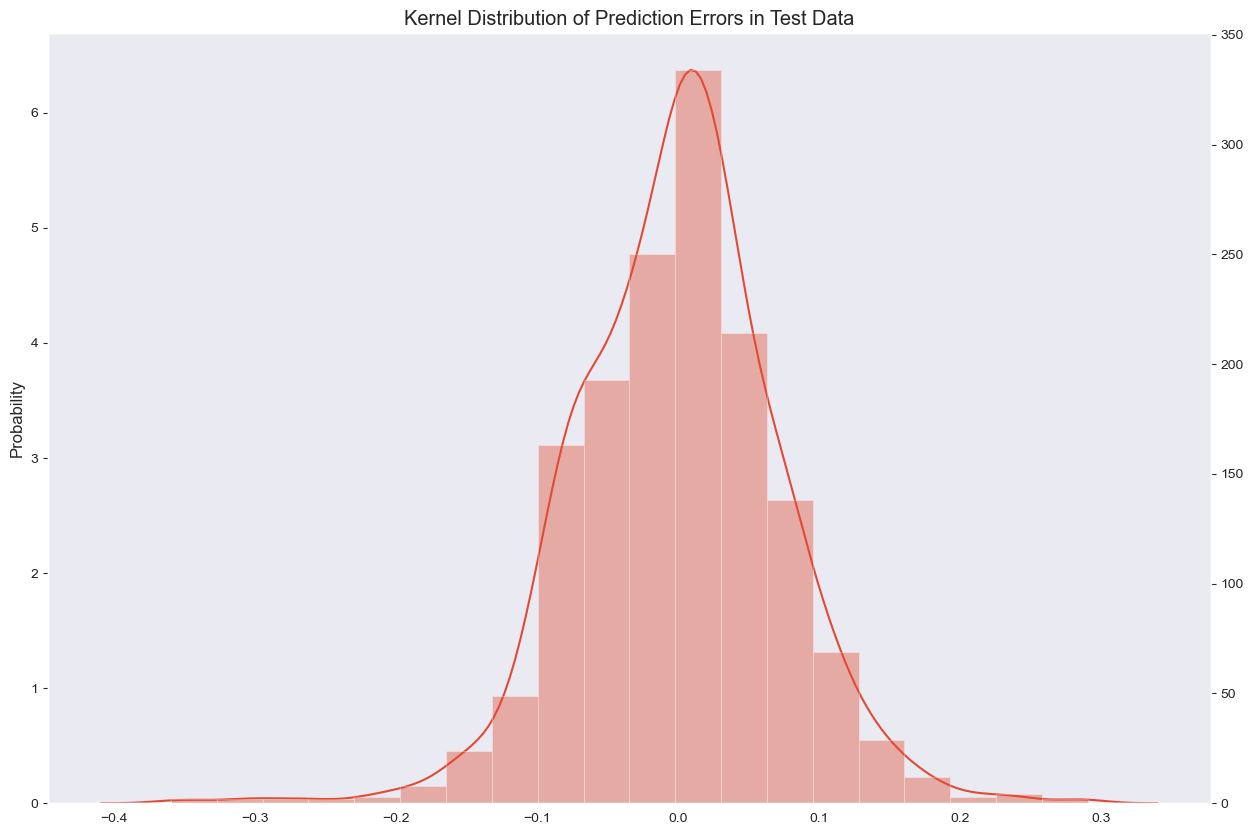

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro3, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro3, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()


In [88]:
#Computamos média e variância para cada ponto no set de teste.

In [89]:
es3

6.4278319131711e-05

In [90]:
ea3

0.0714947219879879

In [91]:
l = 10
y_hat_test_mean = np.mean(y_hat_mc, axis=1) # média das 1000 previsões para cada ponto 
y_hat_test_variance = np.var(y_hat_mc, axis=1) 
tau = l**2 * (1 - p_dropout) / (2 * X_train.shape[0] * lbd)
y_hat_test_variance += tau**-1  # variância das 1000 previsões para cada ponto 

In [92]:
metrics.mean_absolute_error(y_test, y_hat_test_mean)

0.0429963523507189

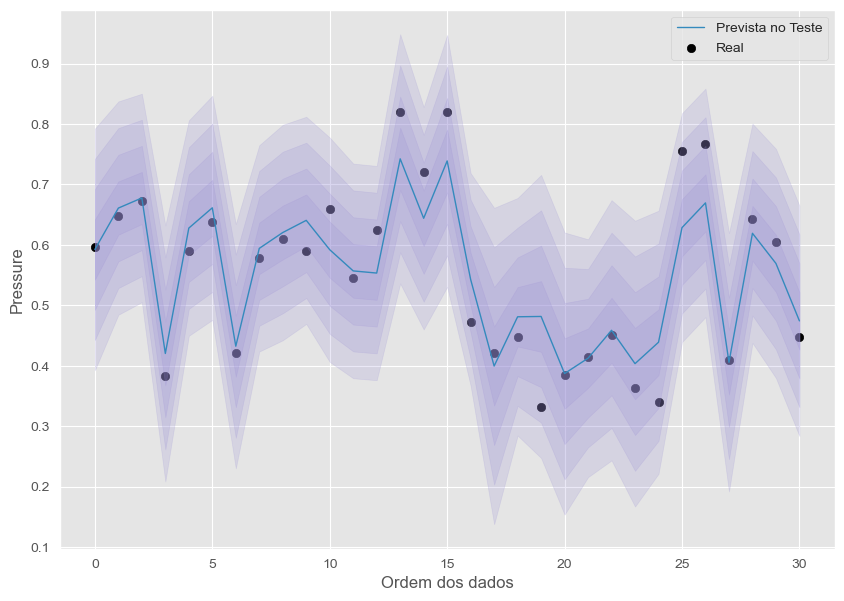

In [93]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Prevista no Teste", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma* (.5*shade), mu-sigma * (.5*shade), alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Ordem dos dados")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

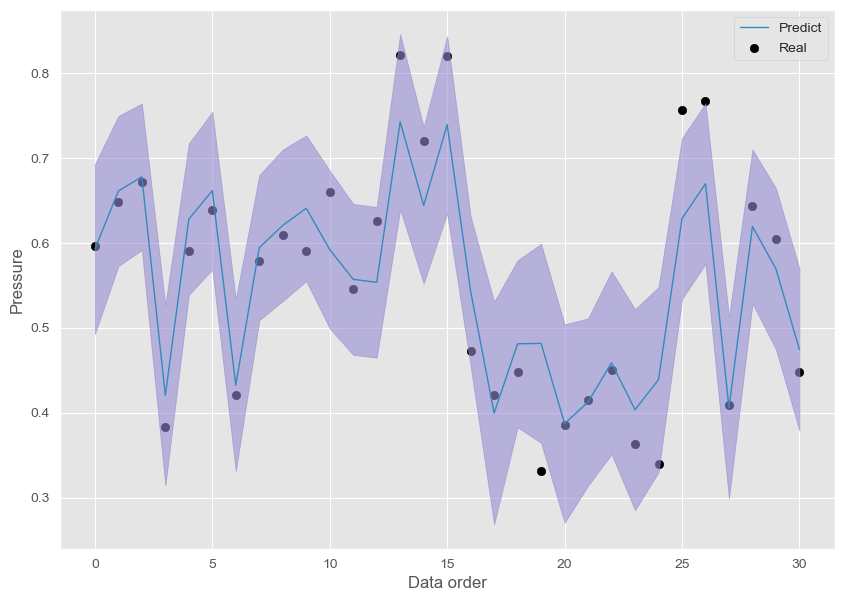

In [94]:
n = 31
t = range(n) 
mu = y_hat_test_mean
sigma = np.sqrt(y_hat_test_variance)

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, mu, label="Predict", color="C1", lw=1)
plt.scatter(t, y_test, color="black", label="Real")

for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma, alpha=0.2, color="C2")

plt.ylabel("Pressure")
plt.xlabel("Data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test.png")
plt.show()

In [95]:
X_test=X_test.reset_index(drop=True)

In [96]:

 previsão=model.predict(X_test[:31])


1/1 [==============================] - 0s 15ms/step


In [97]:
colnames=["Predict"]

In [98]:
previsão1=pd.DataFrame(previsão, columns=colnames)

In [99]:
df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\3988421289.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.resume3=pd.concat([X_test,y_test,previsão1],axis=1)


In [100]:
#criar a coluna de predict delta x1 

In [101]:
#método numerico para derivadsa parcias: método das diferenças onde h=0.000001

In [102]:
h1=0.000001
h2=0.000001
h3=0.000001
h4=0.000001
h5=0.000001

In [103]:
deltax1=X_test[:31]+np.array([h1,0,0,0,0])

In [104]:
previsãodeltax1=model.predict(deltax1[:31])


1/1 [==============================] - 0s 15ms/step


In [105]:
colnames=["Predict Deltax1"]
previsãodeltax1=pd.DataFrame(previsãodeltax1, columns=colnames)

In [106]:
#criar a coluna de predict delta x2

In [107]:
#incerteza de x2 (medidor de ângulo)

In [108]:
deltax2=X_test[:31]+np.array([0,h2,0,0,0])

In [109]:
previsãodeltax2=model.predict(deltax2[:31])

1/1 [==============================] - 0s 15ms/step


In [110]:
colnames=["Predict Deltax2"]
previsãodeltax2=pd.DataFrame(previsãodeltax2, columns=colnames)

In [111]:
#criar a coluna de predict delta x3

In [112]:
#incerteza de x3 (medidor de comprimento)

In [113]:
deltax3=X_test[:31]+np.array([0,0,h3,0,0])

In [114]:
previsãodeltax3=model.predict(deltax3[:31])

1/1 [==============================] - 0s 15ms/step


In [115]:
colnames=["Predict Deltax3"]
previsãodeltax3=pd.DataFrame(previsãodeltax3, columns=colnames)

In [116]:
#criar a coluna de predict delta x4

In [117]:
#incerteza de x4 (medidor de velocidade).

In [118]:
deltax4=X_test[:31]+np.array([0,0,0,h4,0])

In [119]:
previsãodeltax4=model.predict(deltax4[:31])

1/1 [==============================] - 0s 14ms/step


In [120]:
colnames=["Predict Deltax4"]
previsãodeltax4=pd.DataFrame(previsãodeltax4, columns=colnames)

In [121]:
#criar a coluna de predict delta x5

In [122]:
#incerteza de x5 (medidor de sucção)

In [123]:
deltax5=X_test[:31]+np.array([0,0,0,0,h5])

In [124]:
previsãodeltax5=model.predict(deltax5[:31])

1/1 [==============================] - 0s 14ms/step


In [125]:
colnames=["Predict Deltax5"]
previsãodeltax5=pd.DataFrame(previsãodeltax5, columns=colnames)

In [126]:
df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)

C:\Users\AdmPDI\AppData\Local\Temp\ipykernel_6616\2651709830.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.total=pd.concat([y_test,previsão1,previsãodeltax1,previsãodeltax2,previsãodeltax3,previsãodeltax4,previsãodeltax5],axis=1)


In [127]:
df.total['c1']=(df.total['Predict Deltax1']-df.total['Predict'])/h1


In [128]:
df.total['c2']=(df.total['Predict Deltax2']-df.total['Predict'])/h2


In [129]:
df.total['c3']=(df.total['Predict Deltax3']-df.total['Predict'])/h3

In [130]:
df.total['c4']=(df.total['Predict Deltax4']-df.total['Predict'])/h4

In [131]:
df.total['c5']=(df.total['Predict Deltax5']-df.total['Predict'])/h5

In [132]:
#cálculo da incerteza combinada : incerteza expandida de x1 a x5  desvio padrão do erro sistemático
#x1: medidor de frequencia sonora.5% do valor médio da escala
#x2: medidor de angulo :5% do valor médio da escala
#x3: medidor de comprimento 5% do valor médio da escala
#x4: medidor de velocidade do vento Pesquisando a incerteza em tuneis de vento chega a 15% do resultado . Como a velocidade média é em torno de 40 m/s estimou-se em +-6m/s²
#x5: medidor de sucção 5% do valor médio da escala
#y: pressão somora: 5% do valor médio da escala
 

In [133]:
upx1=0.0003468*0.5/2
upx2=0.00488*0.5/2
upx3=0.001470*0.5/2
upx4=0.01966*0.5/2
upx5=0.1*0.5/2
upy=0.008*0.5/2

In [134]:
df_n.rename(columns={
    0: 'Frequency',1:'Angle',2:'Length',3:'Velocity',4:'Suction Side',5:'Pressure'
   
},inplace=True)

In [135]:
correlation= df_n.corr()

In [136]:
correlation

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
Frequency,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Angle,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Suction Side,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
Pressure,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


In [137]:
r_as=correlation['Angle']['Suction Side']

In [138]:
r_al=correlation['Angle']['Length']

<AxesSubplot:>

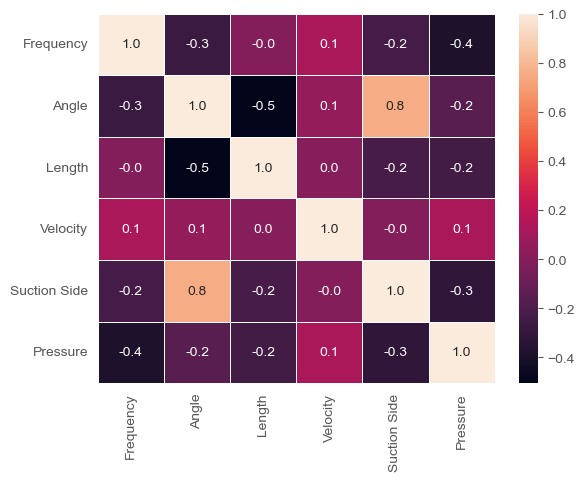

In [139]:
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)

plot

In [140]:
cov= df_n.cov()

In [141]:
cov

,Frequency,Angle,Length,Velocity,Suction Side,Pressure
Frequency,0.025351,-0.011578,-0.000195,0.008369,-0.008305,-0.011412
Angle,-0.011578,0.071066,-0.045059,0.006160,0.045528,-0.007634
Length,-0.000195,-0.045059,0.112085,0.000499,-0.016760,-0.014504
Velocity,0.008369,0.006160,0.000499,0.154647,-0.000354,0.009025
Suction Side,-0.008305,0.045528,-0.016760,-0.000354,0.051387,-0.013002
Pressure,-0.011412,-0.007634,-0.014504,0.009025,-0.013002,0.033651


# incerteza com correlação 

In [142]:
ucca=((df.total['c1']*upx1)**2+
                   (df.total['c2']*upx2)**2+
                   (df.total['c3']*upx3)**2+
                   (df.total['c4']*upx4)**2+
                   (df.total['c5']*upx5)**2+2*df.total['c1']*df.total['c5']*upx1*upx5*r_as+
                   2*df.total['c1']*df.total['c2']*upx1*upx2*r_al+upy**2)**0.5

In [143]:
ucce=((ea)**2)**0.5

In [144]:
ucc=(ucca**2+ucce**2)**0.5

In [145]:
U= 2*ucc+abs(es)

In [146]:
df.total['ucca']=ucca
df.total['ucce']=ucce
df.total['ucc']=ucc
df.total['U']=U

In [147]:
df.total

,5,Predict,Predict Deltax1,Predict Deltax2,Predict Deltax3,Predict Deltax4,Predict Deltax5,c1,c2,c3,c4,c5,ucca,ucce,ucc,U
0,0.596591,0.564548,0.564553,0.564548,0.564549,0.564548,0.564548,4.827976,-0.059605,1.549721,0.000000,-0.178814,0.004658,0.067323,0.067483,0.141469
1,0.648363,0.677328,0.677328,0.677328,0.677328,0.677328,0.677328,-0.357628,0.059605,-0.238419,0.000000,-0.298023,0.007738,0.067323,0.067766,0.142034
2,0.671870,0.681739,0.681739,0.681739,0.681739,0.681739,0.681739,0.178814,0.178814,-0.178814,0.059605,0.178814,0.004922,0.067323,0.067502,0.141507
3,0.383147,0.416209,0.416208,0.416209,0.416209,0.416209,0.416208,-0.596046,-0.238419,-0.119209,0.089407,-0.536442,0.013608,0.067323,0.068684,0.143870
4,0.590555,0.653877,0.653877,0.653877,0.653877,0.653878,0.653877,-0.953674,-0.119209,-0.357628,0.119209,-0.715256,0.018065,0.067323,0.069704,0.145911
5,0.638046,0.680304,0.680300,0.680304,0.680304,0.680304,0.680301,-3.814697,0.178814,-0.178814,0.119209,-2.264977,0.056913,0.067323,0.088156,0.182814
6,0.420906,0.443654,0.443653,0.443653,0.443653,0.443654,0.443653,-1.013279,-0.417233,-0.298023,0.089407,-1.162291,0.029199,0.067323,0.073382,0.153266
7,0.579068,0.588553,0.588558,0.588553,0.588553,0.588553,0.588554,4.708767,0.059605,-0.059605,0.000000,1.132488,0.028690,0.067323,0.073181,0.152864
8,0.609434,0.651074,0.651071,0.651074,0.651074,0.651075,0.651074,-3.278255,-0.476837,-0.298023,0.178814,-0.238419,0.006566,0.067323,0.067642,0.141786
9,0.590342,0.674944,0.674942,0.674944,0.674944,0.674944,0.674944,-2.384186,-0.059605,-0.476837,0.059605,-0.178814,0.005052,0.067323,0.067512,0.141526


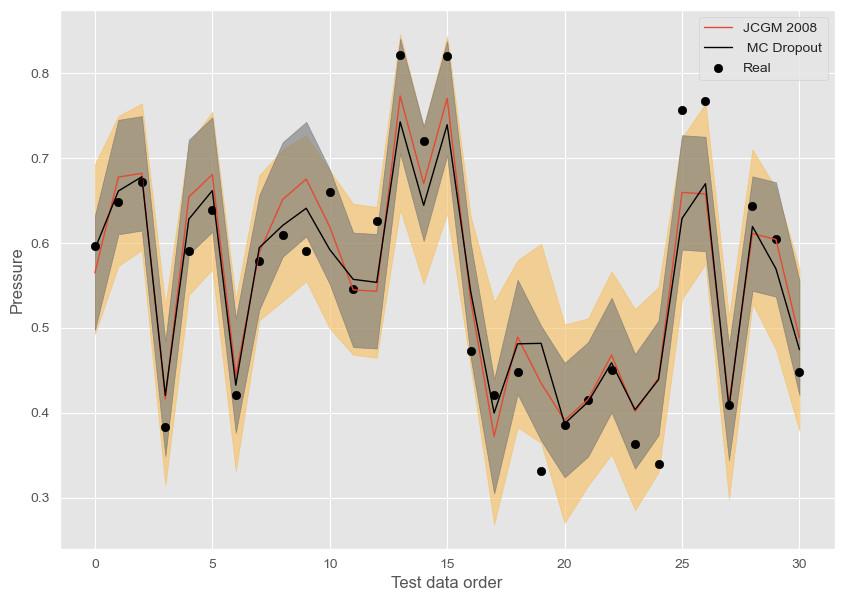

In [148]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, df.total['Predict'], label="JCGM 2008", color="C7", lw=1)
plt.plot(t, mu, label=" MC Dropout", color="Black", lw=1)
for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma , alpha=0.2, color="C11")
for shade in range(1, 5):
    plt.fill_between(t, df.total['Predict']-df.total['ucce'], df.total['Predict']+df.total['ucce'], alpha=0.2, color="C3")

plt.scatter(t, df.total[5], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [149]:
MCCC=pd.concat([df.total[5],df.total['Predict'],df.total['ucca'],df.total['ucce'],df.total['ucc'],df.total['U']],axis=1)

In [150]:
MCCC

,5,Predict,ucca,ucce,ucc,U
0,0.596591,0.564548,0.004658,0.067323,0.067483,0.141469
1,0.648363,0.677328,0.007738,0.067323,0.067766,0.142034
2,0.671870,0.681739,0.004922,0.067323,0.067502,0.141507
3,0.383147,0.416209,0.013608,0.067323,0.068684,0.143870
4,0.590555,0.653877,0.018065,0.067323,0.069704,0.145911
5,0.638046,0.680304,0.056913,0.067323,0.088156,0.182814
6,0.420906,0.443654,0.029199,0.067323,0.073382,0.153266
7,0.579068,0.588553,0.028690,0.067323,0.073181,0.152864
8,0.609434,0.651074,0.006566,0.067323,0.067642,0.141786
9,0.590342,0.674944,0.005052,0.067323,0.067512,0.141526


In [151]:
# Definir os nomes das colunas
nomes_colunas = ['Real','GUM Predict','GUM Aleatoric Uncertainty','GUM Epistemic Uncertainty','GUM Preditive Uncertainty','GUM_U_exp']

# Atribuir os nomes das colunas ao DataFrame
MCCC.columns = nomes_colunas



In [152]:
MCCC

,Real,GUM Predict,GUM Aleatoric Uncertainty,GUM Epistemic Uncertainty,GUM Preditive Uncertainty,GUM_U_exp
0,0.596591,0.564548,0.004658,0.067323,0.067483,0.141469
1,0.648363,0.677328,0.007738,0.067323,0.067766,0.142034
2,0.671870,0.681739,0.004922,0.067323,0.067502,0.141507
3,0.383147,0.416209,0.013608,0.067323,0.068684,0.143870
4,0.590555,0.653877,0.018065,0.067323,0.069704,0.145911
5,0.638046,0.680304,0.056913,0.067323,0.088156,0.182814
6,0.420906,0.443654,0.029199,0.067323,0.073382,0.153266
7,0.579068,0.588553,0.028690,0.067323,0.073181,0.152864
8,0.609434,0.651074,0.006566,0.067323,0.067642,0.141786
9,0.590342,0.674944,0.005052,0.067323,0.067512,0.141526


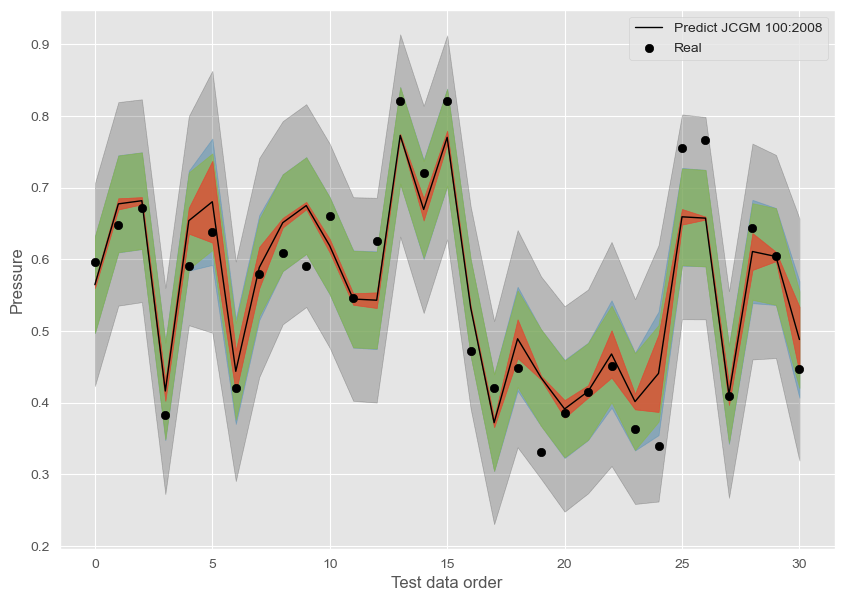

In [153]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='Predict JCGM 100:2008', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM_U_exp'],  MCCC['GUM Predict']+MCCC['GUM_U_exp'], alpha=0.05, color="black")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Preditive Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Preditive Uncertainty'], alpha=0.1, color="C8")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Epistemic Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Epistemic Uncertainty'], alpha=0.2, color="C5")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Aleatoric Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Aleatoric Uncertainty'], alpha=0.3, color="C7")

plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

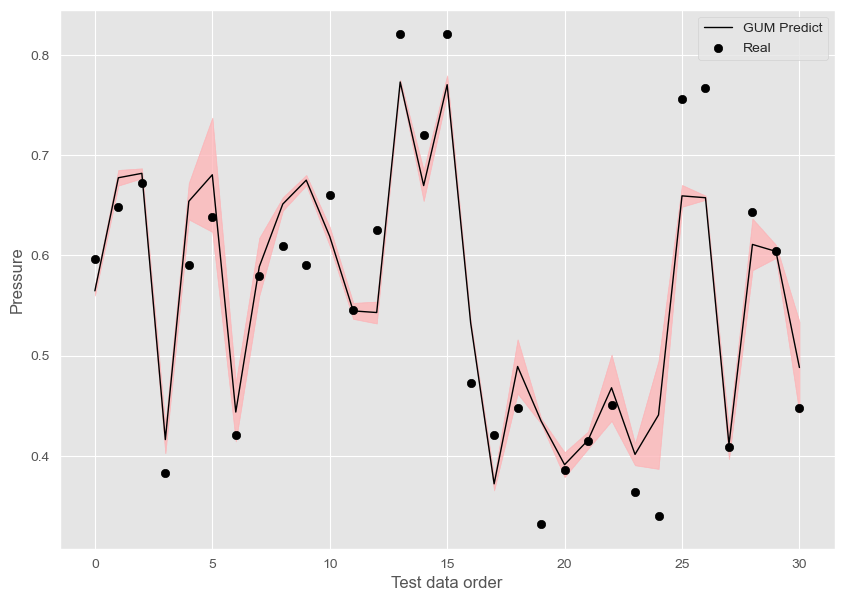

In [154]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='GUM Predict', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Aleatoric Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Aleatoric Uncertainty'], alpha=0.3, color="C20")


plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [155]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))

plt.plot(t, MCCC['MC Predict'], label="Aleatoric Uncertainty (MC)", color="red", lw=1)


for shade in range(1, 5):
    plt.fill_between(t, MCCC['MC Predict']-MCCC['MC Uncertainty'],  MCCC['MC Predict']+MCCC['MC Uncertainty'], alpha=0.08, color="black")

plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

KeyError: 'MC Predict'

<Figure size 1000x700 with 0 Axes>

In [ ]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='Epistemic Uncertainty (GUM)', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Epistemic Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Epistemic Uncertainty'], alpha=0.3, color="C20")


plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [ ]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, MCCC['GUM Predict'], label='Aleatoric Uncertainty(GUM)', color="Black", lw=1)

for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Aleatoric Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Aleatoric Uncertainty'], alpha=0.3, color="C20")

plt.scatter(t, MCCC['Real'], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [ ]:
previsão=pd.DataFrame(previsão)

In [ ]:
sns.histplot(previsão,)

In [ ]:
n = 31
t = range(n) 

plt.style.use("ggplot")
f = plt.figure(figsize=(10,7))
plt.plot(t, df.total['Predict'], label="JCGM 100:2008", color="C7", lw=1)
plt.plot(t, mu, label=" MC Dropout", color="Black", lw=1)
for shade in range(1, 5):
    plt.fill_between(t, mu+sigma, mu-sigma , alpha=0.2, color="C11")
for shade in range(1, 5):
    plt.fill_between(t, MCCC['GUM Predict']-MCCC['GUM Epistemic Uncertainty'],  MCCC['GUM Predict']+MCCC['GUM Epistemic Uncertainty'], alpha=0.2, color="C5")

plt.scatter(t, df.total[5], color="black", label="Real")
plt.ylabel("Pressure")
plt.xlabel("Test data order")
plt.legend(loc="best")
f.savefig("rnn_demanda_test3.png")
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

bins = 20

# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()
# Criando o ambiente do gráfico 
sns.set_style("dark")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Insere curva KDE (Kernel Density Estimation)
g1 = sns.distplot(erro3, ax=ax, 
                  kde=True, hist=False) 

# Insere histograma
ax_copy = ax.twinx()
g2 = sns.distplot(erro3, ax=ax_copy, kde=False, hist=True, 
             bins=bins, norm_hist=False)

# Ajusta rótulos
g1.set_ylabel("Probability")
g2.set_title("Kernel Distribution of Prediction Errors in Test Data")

plt.show()
